# Problem Set 6
### Jonas Katona
#### Math 228B
#### Professor Per-Olof Persson
**Note:** I used Julia 1.0.0 for this problem set.

## Problem 1

One can use a nonlinear hyperbolic PDE (partial differential equation) to model macroscopic traffic flows, which can be derived from continuity and conservation of vehicles on a stretch of roadway:

$$
\frac{\partial\rho}{\partial t}+\frac{\partial\left(\rho u\right)}{\partial x}=0,\quad(1)
$$

where $x$ is position on the roadway in kilometers (km), $t$ is time in units, $\rho=\rho\left(x,t\right)$ is the density of cars (vehicles/km), and $u=u\left(x,t\right)$ is the velocity (km/unit). $(1)$ is in the form of what is called a conservation law (namely, it shows that the cars are conserved). From here, we can define the product $\rho u$ as being equal to $f\left(\rho\right)$, where $f$ is the flux of cars (vehicles/km/s). From here, we need to make some assumption of how the density function $\rho$ and the velocity function $u$ are related. To simplify things, we can assume a linear model. Namely, we will use a model known as the Greenshields model, in which the velocity $u$ is a function of density $\rho$ as

$$
u(\rho\left(x,t\right))=u_{max}\left(1-\frac{\rho\left(x,t\right)}{\rho_{max}}\right),
$$

where $u_{max}$ is the maximum speed on the given stretch of roadway in question (say, the speed limit), and $0\leq\rho\leq\rho_{max}$, such that the density of cars cannot be negative (which is unphysical) and $\rho_{max}$ is the maximum density of cars. (The latter must be enforced, because after all, the cars cannot crash into each other, and each takes up some volume of space.)

Numerically, we can solve this formulation of the traffic flow problem using a first-order finite volume scheme of the form

$$
\rho_{i}^{n+1}=\rho_{i}^{n}-\frac{\Delta t}{\Delta x}\left(F_{i+1/2}^{n}-F_{i-1/2}^{n}\right),\quad(2)
$$

where it is understood that, for $\rho$, superscripts refer to indices in time and subscripts refer to indices in position, such that $\rho_{i}^{n}\approx\rho\left(x_{i},t_{n}\right)$, and for $F$, $F_{i+1/2}^{n}$ is the *numerical* flux function over some cell $\left[x_{i},x_{i+1}\right]$ at some time $t_{n}$. $(2)$ can be derived by applying the integral form of $(1)$ and discretizing it in a neighborhood of radius $\frac{\Delta x}{2}$ about each point $x_{i}$ (i.e. in a cell where all points $x$ in the cell satisfy $\left|x_{i}-x\right|<\frac{\Delta x}{2}$):

$$
\frac{\partial\rho}{\partial t}+\frac{\partial f\left(\rho\right)}{\partial x}=0\Rightarrow\frac{d}{dt}\int_{x_{i}-\frac{\Delta x}{2}}^{x_{i}+\frac{\Delta x}{2}}{\rho dx}=-\int_{x_{i}-\frac{\Delta x}{2}}^{x_{i}+\frac{\Delta x}{2}}{\frac{\partial f\left(\rho\right)}{\partial x}dx}=-\left[f\left(\rho\left(x_{i}+\frac{\Delta x}{2},t\right)\right)-f\left(\rho\left(x_{i}-\frac{\Delta x}{2},t\right)\right)\right],
$$

and from here, we can discretize the integral term on the left via a midpoint Riemann sum in position and then a forward difference in time. Rearranging the result will give us $(2)$.

We want to compare the numerical results from two different schemes: namely, Roe's scheme and Godunov's scheme. These both use the same finite volume scheme $(2)$, and only differ in how they each calculate $F$. For Roe's scheme,

$$
F_{i+1/2}^{n}=\frac{1}{2}\left[f\left(\rho_{i}^{n}\right)+f\left(\rho_{i+1}^{n}\right)\right]-\frac{1}{2}\left|a_{i+1/2}^{n}\right|\left(\rho_{i+1}^{n}-\rho_{i}^{n}\right),
$$

where

$$
a_{i+1/2}^{n}=u_{max}\left(1-\frac{\rho_{i}^{n}+\rho_{i+1}^{n}}{\rho_{max}}\right).
$$

Roe's scheme uses a linearization of the Jacobian of $f\left(\rho\right)$, the actual car flux, and then uses this to approximate the flux in cell $\left[x_{i},x_{i+1}\right]$. It is an approximate Riemann solver, in that the Jacobian is used to approximate the flux in the cell, and in our case, it actually is the same as the first-order upwind scheme. This means that, as shown in lecture, regardless of the size of the stepsize used, it might preserve entropy-violating solutions, giving us possibly incorrect shocks in some cases. However, it is not very computationally costly, and that is where the benefit might lie in using this scheme.

On the other hand, Godunov's scheme is an *exact* Riemann solver. Also as discussed in lecture, it is a monotone, entropy-satisfying scheme, meaning that it will give us the correct shocks, provided that the stepsize is adequate. The numerical flux for Godunov's scheme is given by 

$$
F_{i+1/2}^{n}=\left\{\begin{matrix} \min_{\rho\in\left[\rho_{i}^{n},\rho_{i+1}^{n}\right]}{f\left(\rho\right)},\quad\rho_{i}^{n}<\rho_{i+1}^{n} \\ \max_{\rho\in\left[\rho_{i}^{n},\rho_{i+1}^{n}\right]}{f\left(\rho\right)},\quad\rho_{i}^{n}>\rho_{i+1}^{n} \end{matrix}\right..
$$

Next, we write utility functions which will help compute various quantities necessary for solving the scheme described in $(2)$ with numerical fluxes calculated via Roe's scheme or Godunov's scheme. Namely, `carflux` returns the flux of cars given `ρ`, the density of cars, `umax`, which is $u_{max}$ (a.k.a. the "speed limit"), and `ρmax`, the maximum number of cars allowed over a given distance (a.k.a. the maximum allowed density). `roeflux` returns the numerical flux calculated via Roe's scheme, given `ρi`, the density at the left end of a cell in question, `ρf`, the density at the right end, and `umax` and `ρmax` the same. 

Finally `godunovflux` does the same as for `roeflux`, except using Godunov's scheme. However, we should explain how our function works a little bit more. We note that the flux function is quadratic in $\rho$. Therefore, any local extremum (there can only be up to one) is actually a *global* extremum. Furthermore, if the flux function is concave up, this is a global *minimum*, and a global *maximum* if the flux function is concave down. We calculate each of these for our flux function.

$$
f\left(\rho\right)=\rho u_{max}\left(1-\frac{\rho}{\rho_{max}}\right)\Rightarrow f'\left(\rho\right)=u_{max}-2\frac{\rho u_{max}}{\rho_{max}}\\
\Rightarrow f'\left(\overline{\rho}\right)=u_{max}-2\frac{\overline{\rho} u_{max}}{\rho_{max}}=0\Rightarrow\overline{\rho}=\frac{\rho_{max}}{2}.
$$

Thus, the local extremum for our flux is located at $\overline{\rho}=\rho_{max}/2$. To determine whether this is a flux minimum or a flux maximum, we now check the concavity for our flux function. Since $f''\left(\rho\right)=-\frac{2u_{max}}{\rho_{max}}$, and both $\rho_{max},u_{max}>0$ (we cannot have a negative speed limit nor maximum density), our flux function is always concave down. Therefore, $f\left(\overline{\rho}\right)$ is actually a flux *maximum*.

Hence, by comparing the density at the endpoints of the cell in question relative to the location of the maximum at $\overline{\rho}=\rho_{max}/2$, we can determine the maximum or minimum flux in that cell. If $\overline{\rho}\in\left[\rho_{i},\rho_{i+1}\right]$, then of course, that is where the maximum flux is located. Otherwise, if $\overline{\rho}\not\in\left[\rho_{i},\rho_{i+1}\right]$, then the flux throughout the cell must be completely increasing or decreasing. If the cell lies to the left of $\overline{\rho}$, then the cell maximum is at $\rho_{i+1}$ and the minimum at $\rho_{i}$, because the flux must be increasing leading up to $\overline{\rho}$. However, if the cell lies to the right of $\overline{\rho}$, then the opposite is true, because the flux decreases for all $\rho$ after $\overline{\rho}$.

In [1]:
function carflux(ρ, umax, ρmax)
    f = ρ * umax * (1 - ρ / ρmax)
    return f
end

function roeflux(ρi, ρf, umax, ρmax)
    a = umax * (1 - ((ρi + ρf) / ρmax))
    FR = 0.5 * (carflux(ρi, umax, ρmax) + carflux(ρf, umax, ρmax)) - 0.5 * abs(a) * (ρf - ρi)
    return FR
end

function godunovflux(ρi, ρf, umax, ρmax)
    #calculate distance in ρ from the global maximum flux of cars at 0.5 * ρmax
    #the smaller the distance, the larger the flux must be there
    ρidist = abs(ρi - 0.5 * ρmax)
    ρfdist = abs(ρf - 0.5 * ρmax) 
    if ρi < ρf #we want the minimum flux
        if ρidist < ρfdist #then ρi > ρf
            FG = carflux(ρf, umax, ρmax)
        elseif ρidist > ρfdist #then ρi < ρf
            FG = carflux(ρi, umax, ρmax)
        elseif ρidist == ρfdist #same distance, same flux
            FG = carflux(ρi, umax, ρmax)
        end
    elseif ρi > ρf #we want the maximum flux
        if ρidist < ρfdist #then ρi > ρf
            FG = carflux(ρi, umax, ρmax)
        elseif ρidist > ρfdist #then ρi < ρf
            FG = carflux(ρf, umax, ρmax)
        elseif ρidist == ρfdist #same distance, same flux
            FG = carflux(ρi, umax, ρmax)
        end
        if ρi < 0.5 * ρmax < ρf || ρf < 0.5 * ρmax < ρi 
            #however, if the global maximum flux of cars lies between 
            #the start and end points, choose that one
            FG = carflux(0.5 * ρmax, umax, ρmax)
        end
    elseif ρi == ρf #if the fluxes are equal, then we can just take the raw flux
        FG = carflux(ρi, umax, ρmax)
    end
    return FG
end

godunovflux (generic function with 1 method)

Next, we use these utility functions to find a numerical solution to the problem of a traffic light turning green at time $t=0$. In particular, we want to see the solution at $t=2$ for the following initial conditions and parameters which represent this physical scenario: 

$$
\rho_{max}=1.0,\quad\rho_{L}=0.8,\quad u_{max}=1.0,\\
\rho\left(0\right)=\left\{\begin{matrix} \rho_{L},\quad x<0 \\ 0,\quad x\geq 0 \end{matrix}\right..
$$

For our finite volume scheme outlined in $(2)$, we will use a spatial stepsize of $\Delta x=4/400$ and a timestep of $\Delta t = 0.8\Delta x/u_{max}$. 

The exact solution to this problem is given by the following:

$$
\rho\left(x,t\right)=\left\{\begin{matrix} \rho_{L},\quad x<\left(\frac{\rho_{max}-2\rho_{L}}{\rho_{max}}\right)t \\ \frac{\rho_{max}}{2}\left(1-x/t\right),\quad \left(\frac{\rho_{max}-2\rho_{L}}{\rho_{max}}\right)t\leq x\leq t \\ 0,\quad x>t\end{matrix}\right.,
$$

as solvable via method of characteristics. Therefore, from this theoretical solution, physically, we would expect that, after $t=0$, a shock will form at the location of the discontinuity, as the cars move forward. As cars move forward, the car density decreases, and in response, cars behind them also move forward to fill up the decreasing density in front of them. Thus, the resulting shockwave will be in the form of a line that spreads out backwards and forwards about $t=0$ in time (i.e. the slope of the line decreases from infinity with time at $t=0$ as it moves out in both directions, approaching zero as $t\rightarrow\infty$). We should expect this behavior in our numerical solutions.

**Roe's Scheme**

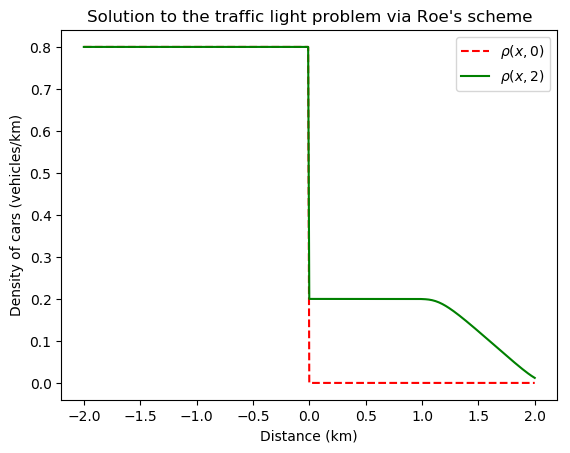

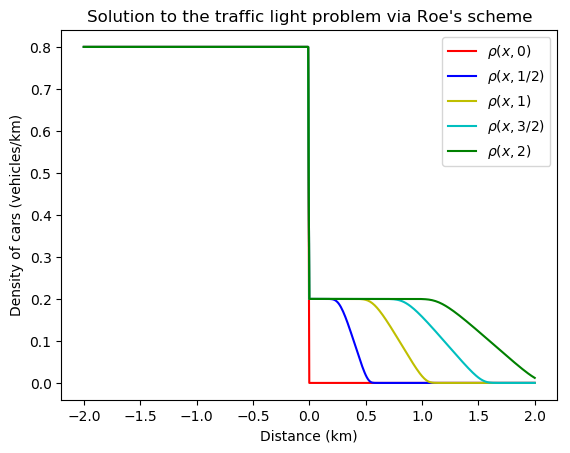

PyObject Text(0.5, 1.0, "Solution to the traffic light problem via Roe's scheme")

In [2]:
using LinearAlgebra
using PyPlot

ρmax = 1.0
umax = 1.0
ρL = 0.8
dx = 4 / 400
dt = 0.8 * dx / umax
xq = -2 : dx : 2
n = length(xq)
tf = 2
tq = 0 : dt : tf

#load initial condition vector
ρi = zeros(n)
for i = 1 : n
    if xq[i] < 0
        ρi[i] = ρL
    else #save time; stop running once at 0
        break
    end
end

ratio = dt / dx
m = length(tq)
ρq = zeros(m, n)
ρq[1, :] = ρi
Fforward = zeros(n)
Fbackward = zeros(n)
for j = 2 : m
    ρqi = ρq[j - 1, :]
    for i = 2 : n - 1 #calculate backwards and forwards fluxes
        Fforward[i] = roeflux(ρqi[i], ρqi[i + 1], umax, ρmax)
        Fbackward[i] = roeflux(ρqi[i - 1], ρqi[i], umax, ρmax)
    end
    #use quadratic interpolation to reconstruct ρ at the boundaries
    #i = 1
    Fforward[1] = roeflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
    #Vandermonde matrix
    A = [1 xq[1] xq[1] ^ 2; 1 xq[2] xq[2] ^ 2; 1 xq[3] xq[3] ^ 2]
    b = [ρqi[1]; ρqi[2]; ρqi[3]]
    coeff = A \ b
    ρq0 = dot(coeff, [1 xq[1] - dx (xq[1] - dx) ^ 2])
    Fbackward[1] = roeflux(ρq0, ρqi[1], umax, ρmax)
    #i = n
    #Vandermonde matrix
    A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
    b = [ρqi[n]; ρqi[n]; ρqi[n]]
    coeff = A \ b
    ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
    Fforward[n] = roeflux(ρqi[n], ρqnplusone, umax, ρmax)
    Fbackward[n] = roeflux(ρqi[n - 1], ρqi[n], umax, ρmax)
    ρq[j, :] = ρqi - ratio * (Fforward - Fbackward) #update with FVM
end

figure(1)
plot(xq, ρq[1, :], "r--", label = L"\rho(x,0)")
plot(xq, ρq[m, :], "g-", label = L"\rho(x,2)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the traffic light problem via Roe's scheme")

figure(2)
plot(xq, ρq[1, :], "r-", label = L"\rho(x,0)")
plot(xq, ρq[Int64(round(m / 4)), :], "b-", label = L"\rho(x,1/2)")
plot(xq, ρq[Int64(round(m / 2)), :], "y-", label = L"\rho(x,1)")
plot(xq, ρq[Int64(round(3 * m / 4)), :], "c-", label = L"\rho(x,3/2)")
plot(xq, ρq[m, :], "g-", label = L"\rho(x,2)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the traffic light problem via Roe's scheme")

Not only does Roe's scheme give us an entropy-violating solution where the characteristics for negative $x$ remain as a straight, vertical line in the $\left(x,t\right)$ plane (when they should form an expansion fan about $x=0$ in the $\left(x,t\right)$ plane), but we do not even get a valid shockwave. Clearly, this solution is unphysical; Roe's scheme not only failed to give us the correct shock, but did not even give us a valid shock in the first place.

**Godunov's Scheme**

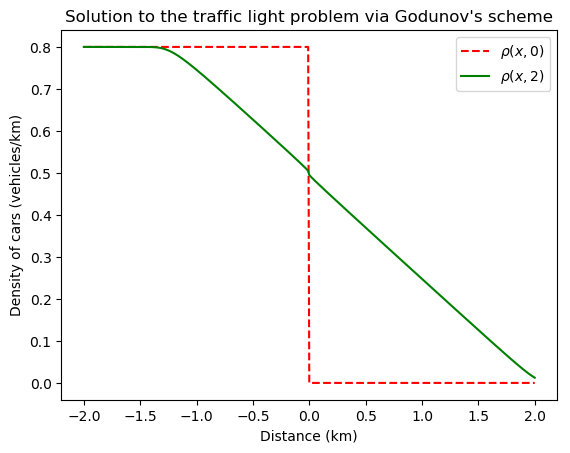

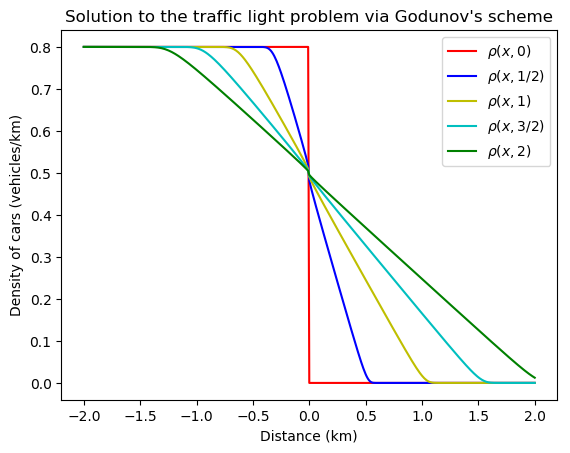

PyObject Text(0.5, 1.0, "Solution to the traffic light problem via Godunov's scheme")

In [3]:
using LinearAlgebra
using PyPlot

ρmax = 1.0
umax = 1.0
ρL = 0.8
dx = 4 / 400
dt = 0.8 * dx / umax
xq = -2 : dx : 2
n = length(xq)
tf = 2
tq = 0 : dt : tf

#load initial condition vector
ρi = zeros(n)
for i = 1 : n
    if xq[i] < 0
        ρi[i] = ρL
    else #save time; stop running once at 0
        break
    end
end

ratio = dt / dx
m = length(tq)
ρq = zeros(m, n)
ρq[1, :] = ρi
Fforward = zeros(n)
Fbackward = zeros(n)
for j = 2 : m
    ρqi = ρq[j - 1, :]
    for i = 2 : n - 1 #calculate backwards and forwards fluxes
        Fforward[i] = godunovflux(ρqi[i], ρqi[i + 1], umax, ρmax)
        Fbackward[i] = godunovflux(ρqi[i - 1], ρqi[i], umax, ρmax)
    end
    #use quadratic interpolation to reconstruct ρ at the boundaries
    #i = 1
    Fforward[1] = godunovflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
    #Vandermonde matrix
    A = [1 xq[1] xq[1] ^ 2; 1 xq[2] xq[2] ^ 2; 1 xq[3] xq[3] ^ 2]
    b = [ρqi[1]; ρqi[2]; ρqi[3]]
    coeff = A \ b
    ρq0 = dot(coeff, [1 xq[1] - dx (xq[1] - dx) ^ 2])
    Fbackward[1] = godunovflux(ρq0, ρqi[1], umax, ρmax)
    #i = n
    #Vandermonde matrix
    A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
    b = [ρqi[n]; ρqi[n]; ρqi[n]]
    coeff = A \ b
    ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
    Fforward[n] = godunovflux(ρqi[n], ρqnplusone, umax, ρmax)
    Fbackward[n] = godunovflux(ρqi[n - 1], ρqi[n], umax, ρmax)
    ρq[j, :] = ρqi- ratio * (Fforward - Fbackward) #update with FVM
end

figure(1)
plot(xq, ρq[1, :], "r--", label = L"\rho(x,0)")
plot(xq, ρq[m, :], "g-", label = L"\rho(x,2)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the traffic light problem via Godunov's scheme")

figure(2)
plot(xq, ρq[1, :], "r-", label = L"\rho(x,0)")
plot(xq, ρq[Int64(round(m / 4)), :], "b-", label = L"\rho(x,1/2)")
plot(xq, ρq[Int64(round(m / 2)), :], "y-", label = L"\rho(x,1)")
plot(xq, ρq[Int64(round(3 * m / 4)), :], "c-", label = L"\rho(x,3/2)")
plot(xq, ρq[m, :], "g-", label = L"\rho(x,2)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the traffic light problem via Godunov's scheme")

On the other hand, Godunov's solution gave us exactly what we expected: a valid shock wave, where the shocks are lines going through $x=0$ at the maximum flux value, or $\rho_{max}/2$. These form fans which approach the vertical line at $x=0$ as $t\rightarrow\infty$. Also, from the theory, we expect that the left side of the shock travels with speed $\frac{\rho_{max}-2\rho_{L}}{\rho_{max}}$, which is equal to $1-2(0.8)=-0.6$ km/unit for our choice of parameters, and that the right side of the shock travels with unit speed. We observe that these are obeyed by our numerical solution given by Godunov's scheme.

## Problem 2

Next, we simulate the effect of a traffic light at $x=-\Delta x/2$ with a period of $T=2$ units. For the first half of the period, the traffic light is red, and the cars cannot move if behind $x=-\Delta x/2$, but for the second half of the period, the traffic light is green, and hence, the cars can move freely throughout the whole spatial domain. Of course, cars can only move in the same direction, which we have set as being to the right. (Physically, this domain represents the section of roadway which we are analyzing.) To simulate this traffic light, whenever the light is red, we can set the *forward* flux (i.e. $F_{i+1/2}$) at $x=-\Delta x/2$ equal to zero and the *backward* flux (i.e. $F_{i-1/2}$) at $x=0$ as both being equal to zero. This represents how, physically, when there is a red light, no cars can move forward at the traffic light (after all, they are stopped), and no cars *could* have moved from behind the traffic light in the cell immediately after the traffic light.

We run our simulation until we reach steady-state, periodic traffic flow. (Note that steady-state in this case does not mean that we expect the traffic flow to not change over a period; rather, after a while, each period $T=2$ yields the same, periodic dynamics.) To gauge if this is reached, we calculate and save the average flow (road capacity) for each period. At a given spatial grid point $x_{i}$, this can be approximated as

$$
\dot{q}_{i}=\frac{1}{m}\sum_{j=1}^{m}{f^{j}}=\frac{1}{m}\sum_{j=1}^{m}{\rho^{j}u^{j}}
$$

for $m$ timesteps per period $T$ (in our code as `m`). (Superscripts in this case are indices in time, NOT exponents.) However, since the road capacity is defined as the flux of cars *per* section of roadway, to calculate the average flow over our whole domain, we need to average this over the entire domain. Thus, for each period over the whole domain, $\dot{q}$ can be approximated as

$$
\dot{q}=\frac{1}{n-2}\sum_{i=2}^{n-1}\left(\frac{1}{m}\sum_{j=1}^{m}{f_{i}^{j}}\right)=\frac{1}{m\left(n-2\right)}\sum_{i=2}^{n-1}\sum_{j=1}^{m}{f_{i}^{j}}=\frac{1}{m\left(n-2\right)}\sum_{i=2}^{n-1}\sum_{j=1}^{m}{f_{i}^{j}}=\frac{1}{m\left(n-2\right)}\sum_{i=2}^{n-1}\sum_{j=1}^{m}{\rho_{i}^{j}u_{i}^{j}}
$$

for $n$ spatial grid points in total. (We omitted the two points at each edge of our spatial domain to avoid boundary effects.)

Our initial conditions we choose are arbitrary: suppose that our roadway is the domain $-3\leq x\leq 3$ and that we start with a mass of cars with density $\rho_{max}/2$ for all points $x<-1.5$.

The average flow (road capacity) over a time period of T=2

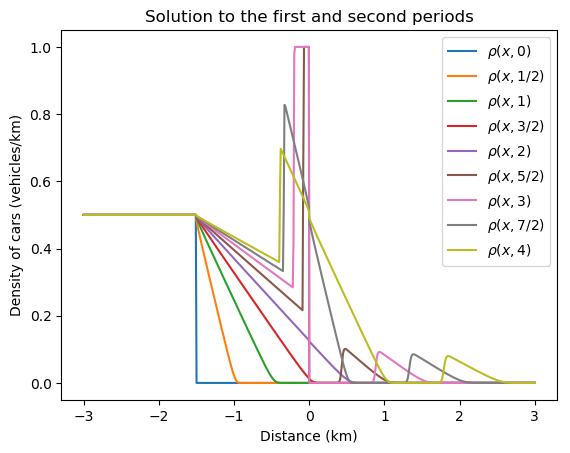

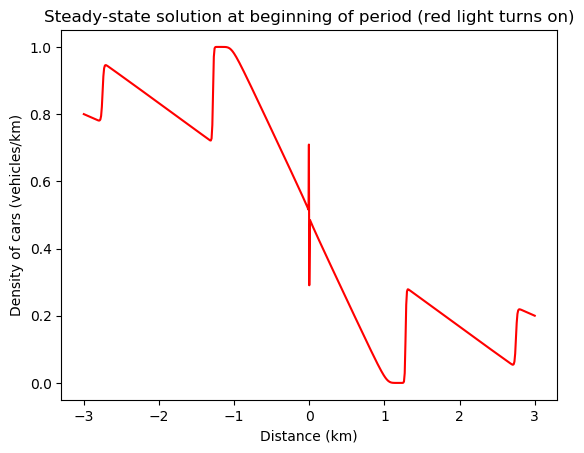

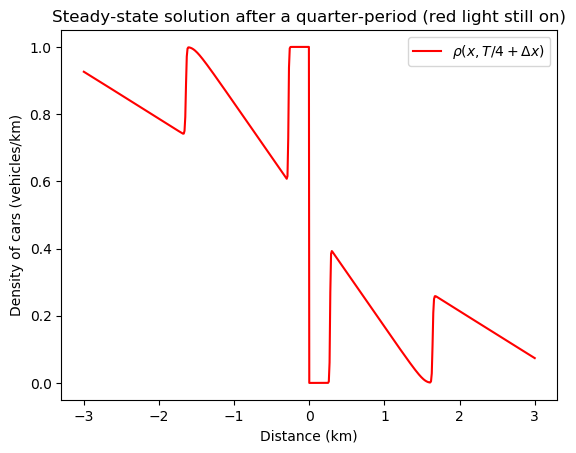

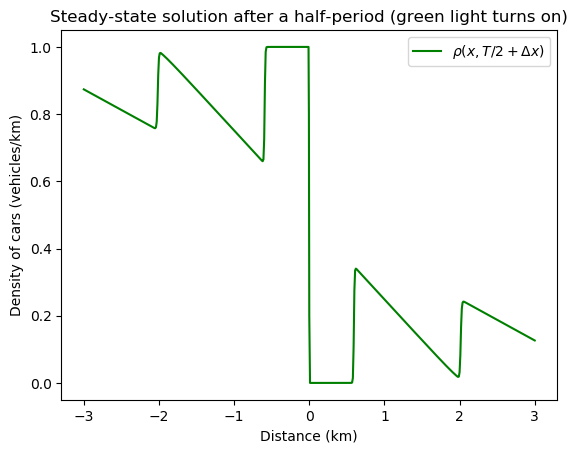

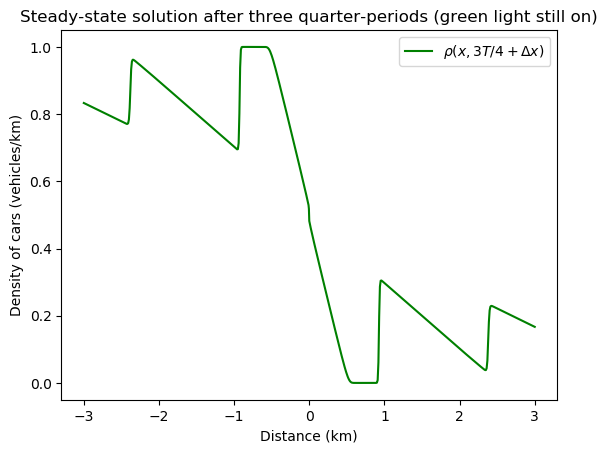

 is 0.12504219648144413.


PyObject Text(0.5, 1.0, 'Steady-state solution after three quarter-periods (green light still on)')

In [4]:
using LinearAlgebra
using PyPlot

ρmax = 1.0
umax = 1.0
dx = 4 / 400
dt = 0.8 * dx / umax
xq = collect(-3 : dx : 3)
n = length(xq)
#insert location of traffic light
xq = insert!(xq, Int64(round(n / 2)) + 1, -dx / 2)
n = length(xq)
T = 2
tq = 0 : dt : T #this is the time vector over one time period

#load initial condition vector
ρi = zeros(n)
for i = 1 : n
    if xq[i] < -1.5
        ρi[i] = ρmax / 2 
    else #save time; stop running once at 0
        break
    end
end

ratio = dt / dx
m = length(tq)
ρq = zeros(m, n) 
ρq[1, :] = ρi
Fforward = zeros(n)
Fbackward = zeros(n)
tol = 1e-9
qdot = [0 1] #just to start off the qdot vector
ρ1 = zeros(m, n)
ρ2 = zeros(m, n)
counter = 0
while abs(qdot[end] - qdot[end - 1]) > tol
    ρq = zeros(m, n) #reset the ρ vector
    ρq[1, :] = ρi #start where we ended on the last period
    for j = 2 : m
        ρqi = ρq[j - 1, :]
        for i = 2 : n - 1 #calculate backwards and forwards fluxes
            Fforward[i] = godunovflux(ρqi[i], ρqi[i + 1], umax, ρmax)
            Fbackward[i] = godunovflux(ρqi[i - 1], ρqi[i], umax, ρmax)
        end
        #i = 1
        Fforward[1] = godunovflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
        #set maximum flux at the left boundary
        ρq0 = ρmax / 2 
        Fbackward[1] = godunovflux(ρq0, ρqi[1], umax, ρmax)
        #use quadratic interpolation to reconstruct ρ at the right boundary
        #i = n
        #Vandermonde matrix
        A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
        b = [ρqi[n]; ρqi[n]; ρqi[n]]
        coeff = A \ b
        ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
        Fforward[n] = godunovflux(ρqi[n], ρqnplusone, umax, ρmax)
        Fbackward[n] = godunovflux(ρqi[n - 1], ρqi[n], umax, ρmax)
        if tq[j] <= T / 2 #red light
            Fforward[Int64(round(n / 2))] = 0.0 #forward flux zero at red light
            Fbackward[Int64(round(n / 2)) + 1] = 0.0 #backward flux zero after red light
        end
        ρq[j, :] = ρqi - ratio * (Fforward - Fbackward) #update with FVM
    end
    u = umax * (1 .- (ρq[:, 2 : end - 1] / ρmax))
    qdot = hcat(qdot, sum(ρq[:, 2 : end - 1] .* u) / (m * (n - 2))) #average flow over interior points
    ρi = ρq[m, :]
    if counter == 0
        ρ1 = ρq
        counter += 1
    elseif counter == 1 
        ρ2 = ρq
        counter += 1
    end
end
println("The average flow (road capacity) over a time period of T=", T, " is ", qdot[end], ".")

figure(1)
plot(xq, ρ1[1, :], label = L"\rho(x,0)")
plot(xq, ρ1[Int64(round(m / 4)), :], label = L"\rho(x,1/2)")
plot(xq, ρ1[Int64(round(m / 2)), :], label = L"\rho(x,1)")
plot(xq, ρ1[Int64(round(3 * m / 4)), :], label = L"\rho(x,3/2)")
plot(xq, ρ1[m, :], label = L"\rho(x,2)")
plot(xq, ρ2[Int64(round(m / 4)), :], label = L"\rho(x,5/2)")
plot(xq, ρ2[Int64(round(m / 2)), :], label = L"\rho(x,3)")
plot(xq, ρ2[Int64(round(3 * m / 4)), :], label = L"\rho(x,7/2)")
plot(xq, ρ2[m, :], label = L"\rho(x,4)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the first and second periods")

figure(2)
plot(xq, ρq[2, :], "r-", label = L"\rho(x,\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution at beginning of period (red light turns on)")

figure(3)
plot(xq, ρq[Int64(round(m / 4)) + 1, :], "r-", label = L"\rho(x,T/4+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after a quarter-period (red light still on)")

figure(4)
plot(xq, ρq[Int64(round(m / 2)) + 1, :], "g-", label = L"\rho(x,T/2+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after a half-period (green light turns on)")

figure(5)
plot(xq, ρq[Int64(round(3 * m / 4)) + 1, :], "g-", label = L"\rho(x,3T/4+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after three quarter-periods (green light still on)")

We modify our condition below to be the same as in problem 1, and we still reach the same steady-state periodic solution, as expected, showing consistency in our approach.

The average flow (road capacity) over a time period of T=2 is 0.12504219648144413.


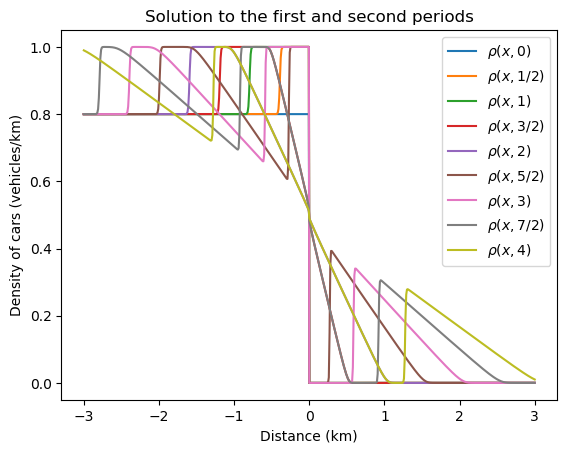

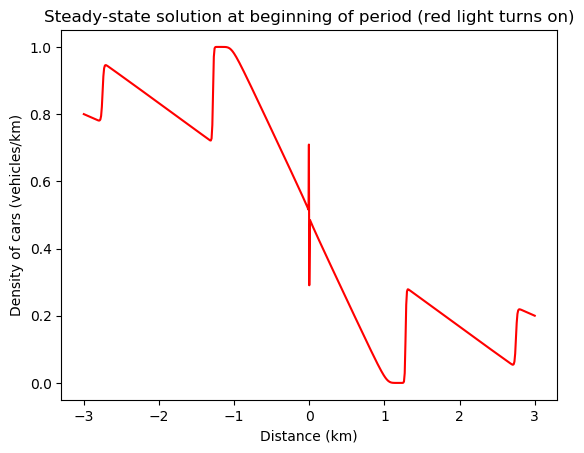

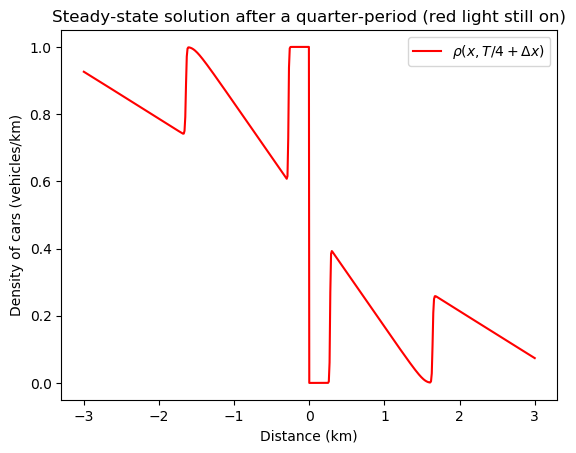

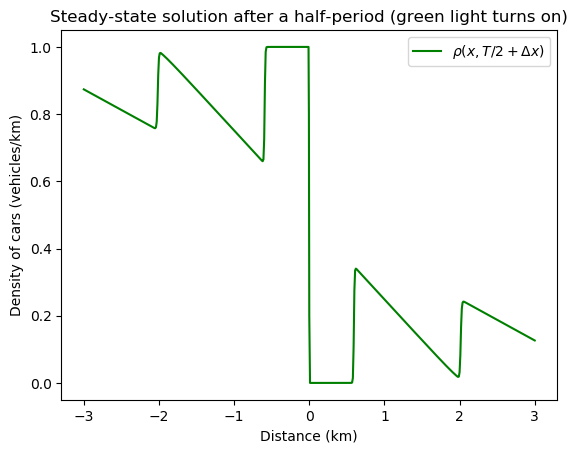

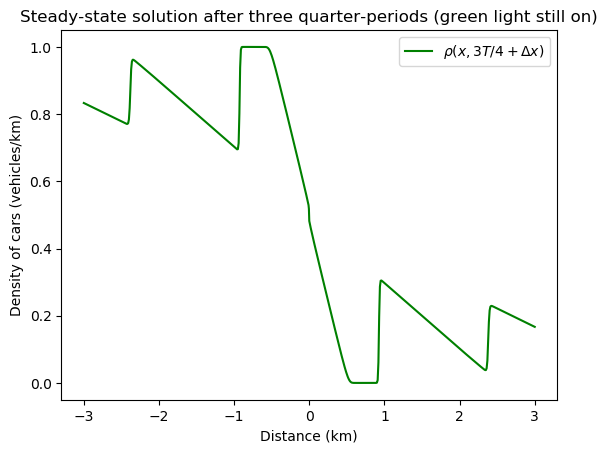

The average flow (road capacity) over a time period of T=2 is 0.12504219648144413.


PyObject Text(0.5, 1.0, 'Steady-state solution after three quarter-periods (green light still on)')

In [5]:
using LinearAlgebra
using PyPlot

ρmax = 1.0
umax = 1.0
dx = 4 / 400
dt = 0.8 * dx / umax
xq = collect(-3 : dx : 3)
n = length(xq)
#insert location of traffic light
xq = insert!(xq, Int64(round(n / 2)) + 1, -dx / 2)
n = length(xq)
T = 2
tq = 0 : dt : T #this is the time vector over one time period

#load initial condition vector; this time a mass of cars starting at the light
for i = 1 : n
    if xq[i] < 0
        ρi[i] = 0.8
    else #save time; stop running once at 0
        break
    end
end

ratio = dt / dx
m = length(tq)
ρq = zeros(m, n) 
ρq[1, :] = ρi
Fforward = zeros(n)
Fbackward = zeros(n)
tol = 1e-9
qdot = [0 1] #just to start off the qdot vector
ρ1 = zeros(m, n)
ρ2 = zeros(m, n)
counter = 0
while abs(qdot[end] - qdot[end - 1]) > tol
    ρq = zeros(m, n) #reset the ρ vector
    ρq[1, :] = ρi #start where we ended on the last period
    for j = 2 : m
        ρqi = ρq[j - 1, :]
        for i = 2 : n - 1 #calculate backwards and forwards fluxes
            Fforward[i] = godunovflux(ρqi[i], ρqi[i + 1], umax, ρmax)
            Fbackward[i] = godunovflux(ρqi[i - 1], ρqi[i], umax, ρmax)
        end
        #i = 1
        Fforward[1] = godunovflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
        ρq0 = 0.8
        Fbackward[1] = godunovflux(ρq0, ρqi[1], umax, ρmax)
        #use quadratic interpolation to reconstruct ρ at the right boundary
        #i = n
        #Vandermonde matrix
        A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
        b = [ρqi[n]; ρqi[n]; ρqi[n]]
        coeff = A \ b
        ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
        Fforward[n] = godunovflux(ρqi[n], ρqnplusone, umax, ρmax)
        Fbackward[n] = godunovflux(ρqi[n - 1], ρqi[n], umax, ρmax)
        if tq[j] <= T / 2 #red light
            Fforward[Int64(round(n / 2))] = 0.0 #forward flux zero at red light
            Fbackward[Int64(round(n / 2)) + 1] = 0.0 #backward flux zero after red light
        end
        ρq[j, :] = ρqi - ratio * (Fforward - Fbackward) #update with FVM
    end
    u = umax * (1 .- (ρq[:, 2 : end - 1] / ρmax))
    qdot = hcat(qdot, sum(ρq[:, 2 : end - 1] .* u) / (m * (n - 2))) #average flow over interior points
    ρi = ρq[m, :]
    if counter == 0
        ρ1 = ρq
        counter += 1
    elseif counter == 1 
        ρ2 = ρq
        counter += 1
    end
end
println("The average flow (road capacity) over a time period of T=", T, " is ", qdot[end], ".")

using LinearAlgebra
using PyPlot

ρmax = 1.0
umax = 1.0
dx = 4 / 400
dt = 0.8 * dx / umax
xq = collect(-3 : dx : 3)
n = length(xq)
#insert location of traffic light
xq = insert!(xq, Int64(round(n / 2)) + 1, -dx / 2)
n = length(xq)
T = 2
tq = 0 : dt : T #this is the time vector over one time period

#load initial condition vector
ρi = zeros(n)
for i = 1 : n
    if xq[i] < 0
        ρi[i] = 0.8
    else #save time; stop running once at 0
        break
    end
end

ratio = dt / dx
m = length(tq)
ρq = zeros(m, n) 
ρq[1, :] = ρi
Fforward = zeros(n)
Fbackward = zeros(n)
tol = 1e-9
qdot = [0 1] #just to start off the qdot vector
ρ1 = zeros(m, n)
ρ2 = zeros(m, n)
counter = 0
while abs(qdot[end] - qdot[end - 1]) > tol
    ρq = zeros(m, n) #reset the ρ vector
    ρq[1, :] = ρi #start where we ended on the last period
    for j = 2 : m
        ρqi = ρq[j - 1, :]
        for i = 2 : n - 1 #calculate backwards and forwards fluxes
            Fforward[i] = godunovflux(ρqi[i], ρqi[i + 1], umax, ρmax)
            Fbackward[i] = godunovflux(ρqi[i - 1], ρqi[i], umax, ρmax)
        end
        #i = 1
        Fforward[1] = godunovflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
        ρq0 = 0.8
        Fbackward[1] = godunovflux(ρq0, ρqi[1], umax, ρmax)
        #use quadratic interpolation to reconstruct ρ at the right boundary
        #i = n
        #Vandermonde matrix
        A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
        b = [ρqi[n]; ρqi[n]; ρqi[n]]
        coeff = A \ b
        ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
        Fforward[n] = godunovflux(ρqi[n], ρqnplusone, umax, ρmax)
        Fbackward[n] = godunovflux(ρqi[n - 1], ρqi[n], umax, ρmax)
        if tq[j] <= T / 2 #red light
            Fforward[Int64(round(n / 2))] = 0.0 #forward flux zero at red light
            Fbackward[Int64(round(n / 2)) + 1] = 0.0 #backward flux zero after red light
        end
        ρq[j, :] = ρqi - ratio * (Fforward - Fbackward) #update with FVM
    end
    u = umax * (1 .- (ρq[:, 2 : end - 1] / ρmax))
    qdot = hcat(qdot, sum(ρq[:, 2 : end - 1] .* u) / (m * (n - 2))) #average flow over interior points
    ρi = ρq[m, :]
    if counter == 0
        ρ1 = ρq
        counter += 1
    elseif counter == 1 
        ρ2 = ρq
        counter += 1
    end
end
println("The average flow (road capacity) over a time period of T=", T, " is ", qdot[end], ".")

figure(1)
plot(xq, ρ1[1, :], label = L"\rho(x,0)")
plot(xq, ρ1[Int64(round(m / 4)), :], label = L"\rho(x,1/2)")
plot(xq, ρ1[Int64(round(m / 2)), :], label = L"\rho(x,1)")
plot(xq, ρ1[Int64(round(3 * m / 4)), :], label = L"\rho(x,3/2)")
plot(xq, ρ1[m, :], label = L"\rho(x,2)")
plot(xq, ρ2[Int64(round(m / 4)), :], label = L"\rho(x,5/2)")
plot(xq, ρ2[Int64(round(m / 2)), :], label = L"\rho(x,3)")
plot(xq, ρ2[Int64(round(3 * m / 4)), :], label = L"\rho(x,7/2)")
plot(xq, ρ2[m, :], label = L"\rho(x,4)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the first and second periods")

figure(2)
plot(xq, ρq[2, :], "r-", label = L"\rho(x,\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution at beginning of period (red light turns on)")

figure(3)
plot(xq, ρq[Int64(round(m / 4)) + 1, :], "r-", label = L"\rho(x,T/4+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after a quarter-period (red light still on)")

figure(4)
plot(xq, ρq[Int64(round(m / 2)) + 1, :], "g-", label = L"\rho(x,T/2+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after a half-period (green light turns on)")

figure(5)
plot(xq, ρq[Int64(round(3 * m / 4)) + 1, :], "g-", label = L"\rho(x,3T/4+\Delta x)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Steady-state solution after three quarter-periods (green light still on)")

## Problem 3

In [6]:
using LinearAlgebra
using PyPlot

function roadcapacity(ρmax, umax, T, τ, x2, tol)
    dx = 4 / 400
    dt = 0.8 * dx / umax
    xq = collect(-3 : dx : 3)
    n = length(xq)
    tq = 0 : dt : T #this is the time vector over one time period

    #load initial condition vector
    ρi = zeros(n)
    for i = 1 : n
        if xq[i] < -1.5
            ρi[i] = ρmax / 2 
        else #save time; stop running once at 0
            break
        end
    end

    ratio = dt / dx
    m = length(tq)
    ρq = zeros(m, n) 
    ρq[1, :] = ρi
    Fforward = zeros(n)
    Fbackward = zeros(n)
    qdot = [0 1] #just to start off the qdot vector
    ρ1 = zeros(m, n)
    ρ2 = zeros(m, n)
    counter = 0
    while abs(qdot[end] - qdot[end - 1]) > tol
        ρq = zeros(m, n) #reset the ρ vector
        ρq[1, :] = ρi #start where we ended on the last period
        for j = 2 : m
            ρqi = ρq[j - 1, :]
            for i = 2 : n - 1 #calculate backwards and forwards fluxes
                Fforward[i] = godunovflux(ρqi[i], ρqi[i + 1], umax, ρmax)
                Fbackward[i] = godunovflux(ρqi[i - 1], ρqi[i], umax, ρmax)
            end
            #i = 1
            Fforward[1] = godunovflux(ρqi[1], ρqi[1 + 1], umax, ρmax)
            #set maximum flux at the left boundary
            ρq0 = 0.8
            Fbackward[1] = godunovflux(ρq0, ρqi[1], umax, ρmax)
            #use quadratic interpolation to reconstruct ρ at the right boundary
            #i = n
            #Vandermonde matrix
            A = [1 xq[n] xq[n] ^ 2; 1 xq[n - 1] xq[n - 1] ^ 2; 1 xq[n - 2] xq[n - 2] ^ 2]
            b = [ρqi[n]; ρqi[n]; ρqi[n]]
            coeff = A \ b
            ρqnplusone = dot(coeff, [1 xq[n] + dx (xq[n] + dx) ^ 2])
            Fforward[n] = godunovflux(ρqi[n], ρqnplusone, umax, ρmax)
            Fbackward[n] = godunovflux(ρqi[n - 1], ρqi[n], umax, ρmax)
            if tq[j] <= T / 2 #red light; impose that F,ρ=0 at x=0
                index1 = findall(x -> x == 0.0, xq)[1]
                Fforward[index1] = 0.0 #forward flux zero at red light
                Fbackward[index1 + 1] = 0.0 #backward flux zero after red light
            end
            #`mod` is used, because the signals are periodic by T
            if mod(τ, T) > T / 2 #in this case, the red light region is disconnected in time for each period
                if tq[j] <= mod(τ, T) - (T / 2) || tq[j] > mod(τ, T) #red light; impose that F,ρ=0 at x=0.15  
                    index2 = findall(x -> x == x2, xq)[1]
                    Fforward[index2] = 0.0 #forward flux zero at red light
                    Fbackward[index2 + 1] = 0.0 #backward flux zero after red light
                end 
            else #otherwise, the red light region is connected in time
                if tq[j] <= mod(τ, T) + (T / 2) && tq[j] > mod(τ, T) #red light; impose that F,ρ=0 at x=0.15  
                    index2 = findall(x -> x == x2, xq)[1]
                    Fforward[index2] = 0.0 #forward flux zero at red light
                    Fbackward[index2 + 1] = 0.0 #backward flux zero after red light
                end     
            end
            ρq[j, :] = ρqi - ratio * (Fforward - Fbackward) #update with FVM
        end
        u = umax * (1 .- (ρq[:, 2 : end - 1] / ρmax))
        qdot = hcat(qdot, sum(ρq[:, 2 : end - 1] .* u) / (m * (n - 2))) #average flow over interior points
        ρi = ρq[m, :]
        if counter == 0
            ρ1 = ρq
            counter += 1
        elseif counter == 1 
            ρ2 = ρq
            counter += 1
        end
    end
    return qdot[end], xq, ρq, ρ1, ρ2
end

roadcapacity (generic function with 1 method)

The optimal delay (τ) over a time period of T=2 is 1.8.
The road capacity at this optimal delay is 0.12517633375004697.
The least optimal delay (τ) over a time period of T=2 is 

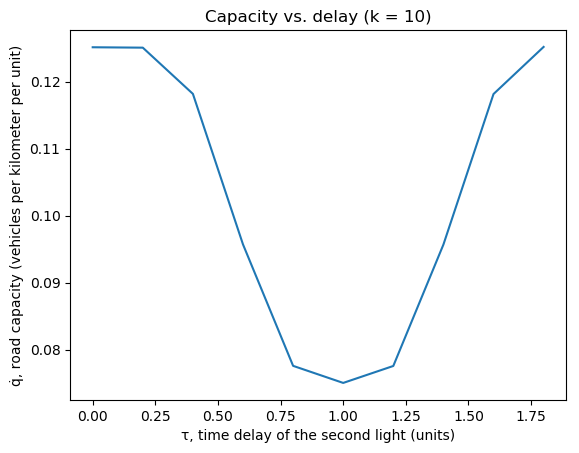

1.0.
The road capacity at this least optimal delay is 0.07502780838043749.


In [7]:
ρmax = 1.0
umax = 1.0
T = 2
kq = 0 : 9
τq = (T / 10) * kq
tol = 1e-9
x2 = 0.15

k = length(kq)
capacityq = zeros(k)
for i = 1 : k
    qdot, xq, ρq, ρ1, ρ2 = roadcapacity(ρmax, umax, T, τq[i], x2, tol)
    capacityq[i] = qdot
end

plot(τq, capacityq)
xlabel("τ, time delay of the second light (units)")
ylabel("q̇, road capacity (vehicles per kilometer per unit)")
title("Capacity vs. delay (k = 10)")

qdotmax = maximum(capacityq)
indmax = findall(a -> a == qdotmax, capacityq)[1]
τoptimal = τq[indmax]
println("The optimal delay (τ) over a time period of T=", T, " is ", τoptimal, ".")
println("The road capacity at this optimal delay is ", qdotmax, ".")

qdotmin = minimum(capacityq)
indmin = findall(a -> a == qdotmin, capacityq)[1]
τworst = τq[indmin]
println("The least optimal delay (τ) over a time period of T=", T, " is ", τworst, ".")
println("The road capacity at this least optimal delay is ", qdotmin, ".")

The optimal delay (τ) over a time period of T=2 is 0.28.
The road capacity at this optimal delay is 0.12524218700227324.
The least optimal delay (τ) over a time period of T=

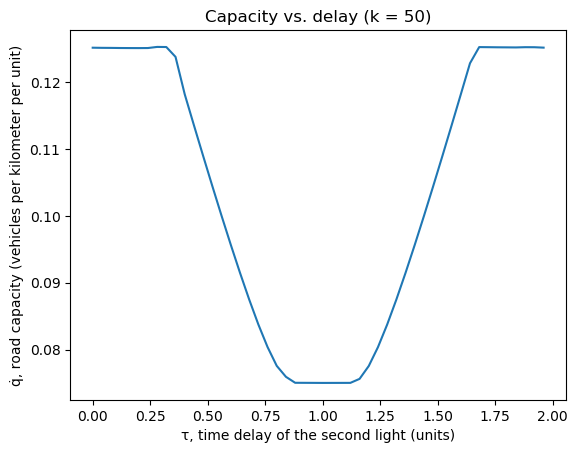

2 is 1.0.
The road capacity at this least optimal delay is 0.07502780838043749.


In [8]:
ρmax = 1.0
umax = 1.0
T = 2
kq = 0 : 49
k = length(kq)
τq = (T / k) * kq
tol = 1e-9
x2 = 0.15

capacityq = zeros(k)
for i = 1 : k
    qdot, xq, ρq, ρ1, ρ2 = roadcapacity(ρmax, umax, T, τq[i], x2, tol)
    capacityq[i] = qdot
end

plot(τq, capacityq)
xlabel("τ, time delay of the second light (units)")
ylabel("q̇, road capacity (vehicles per kilometer per unit)")
title("Capacity vs. delay (k = 50)")

qdotmax = maximum(capacityq)
indmax = findall(a -> a == qdotmax, capacityq)[1]
τoptimal = τq[indmax]
println("The optimal delay (τ) over a time period of T=", T, " is ", τoptimal, ".")
println("The road capacity at this optimal delay is ", qdotmax, ".")

qdotmin = minimum(capacityq)
indmin = findall(a -> a == qdotmin, capacityq)[1]
τworst = τq[indmin]
println("The least optimal delay (τ) over a time period of T=", T, " is ", τworst, ".")
println("The road capacity at this least optimal delay is ", qdotmin, ".")

We plot the steady-state periodic solutions for if the second traffic light uses the optimal delay, and if it uses the least optimal delay.

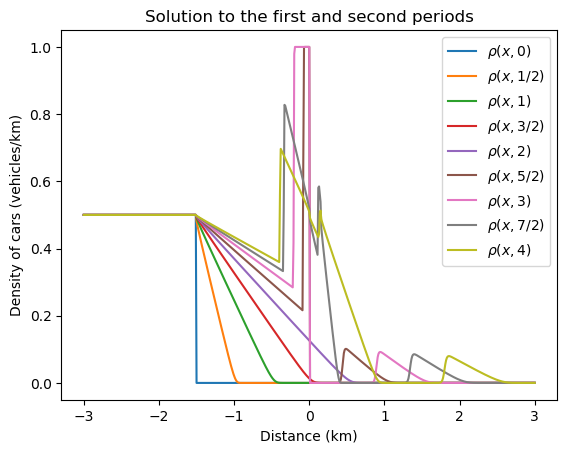

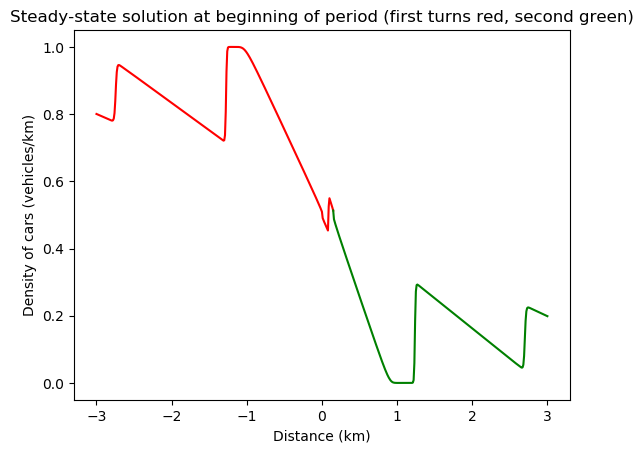

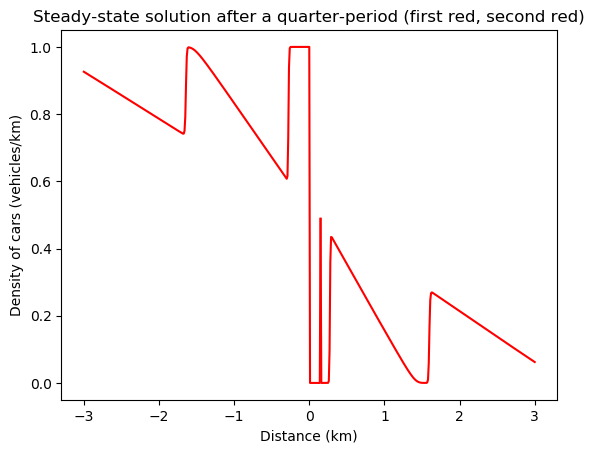

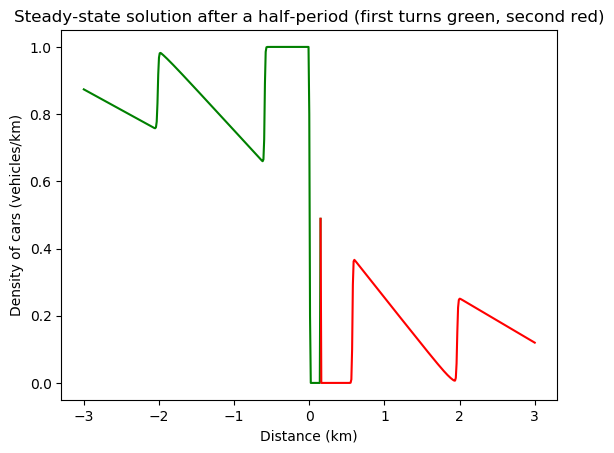

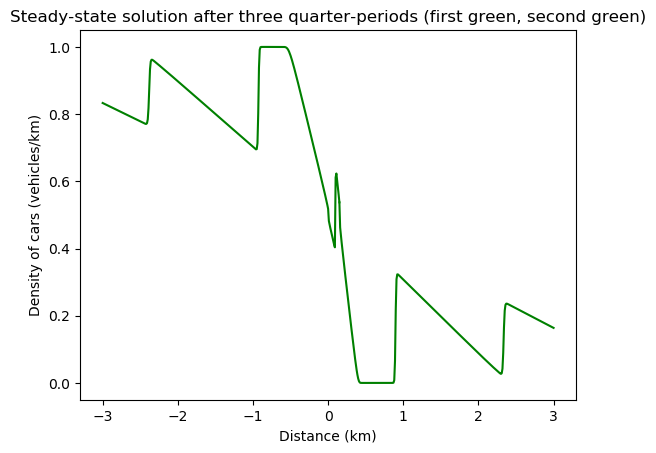

The average flow (road capacity) over a time period of T=2 is 0.12524218700227324.


PyObject Text(0.5, 1.0, 'Steady-state solution after three quarter-periods (first green, second green)')

In [9]:
ρmax = 1.0
umax = 1.0
T = 2 
τ = 0.28
tol = 1e-9
x2 = 0.15

capacity, xq, ρq, ρ1, ρ2 = roadcapacity(ρmax, umax, T, τ, x2, tol)

println("The average flow (road capacity) over a time period of T=", T, " is ", capacity, ".")

figure(1)
plot(xq, ρ1[1, :], label = L"\rho(x,0)")
plot(xq, ρ1[Int64(round(m / 4)), :], label = L"\rho(x,1/2)")
plot(xq, ρ1[Int64(round(m / 2)), :], label = L"\rho(x,1)")
plot(xq, ρ1[Int64(round(3 * m / 4)), :], label = L"\rho(x,3/2)")
plot(xq, ρ1[m, :], label = L"\rho(x,2)")
plot(xq, ρ2[Int64(round(m / 4)), :], label = L"\rho(x,5/2)")
plot(xq, ρ2[Int64(round(m / 2)), :], label = L"\rho(x,3)")
plot(xq, ρ2[Int64(round(3 * m / 4)), :], label = L"\rho(x,7/2)")
plot(xq, ρ2[m, :], label = L"\rho(x,4)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the first and second periods")

loc2 = Int64(round((n / 2) + (0.15 / dx))) #index where x=0.15

figure(2)
plot(xq[1 : loc2], ρq[1, 1 : loc2], "r-")
plot(xq[loc2 : end], ρq[1, loc2 : end], "g-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution at beginning of period (first turns red, second green)")

figure(3)
plot(xq[1 : loc2], ρq[Int64(round(m / 4)) + 1, 1 : loc2], "r-")
plot(xq[loc2 : end], ρq[Int64(round(m / 4)) + 1, loc2 : end], "r-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after a quarter-period (first red, second red)")

figure(4)
plot(xq[1 : loc2], ρq[Int64(round(m / 2)) + 1, 1 : loc2], "g-")
plot(xq[loc2 : end], ρq[Int64(round(m / 2)) + 1, loc2 : end], "r-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after a half-period (first turns green, second red)")

figure(5)
plot(xq[1 : loc2], ρq[Int64(round(3 * m / 4)) + 1, 1 : loc2], "g-")
plot(xq[loc2 : end], ρq[Int64(round(3 * m / 4)) + 1, loc2 : end], "g-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after three quarter-periods (first green, second green)")

The average flow (road capacity) over a time period of T=2 is 0.07502780838043749.


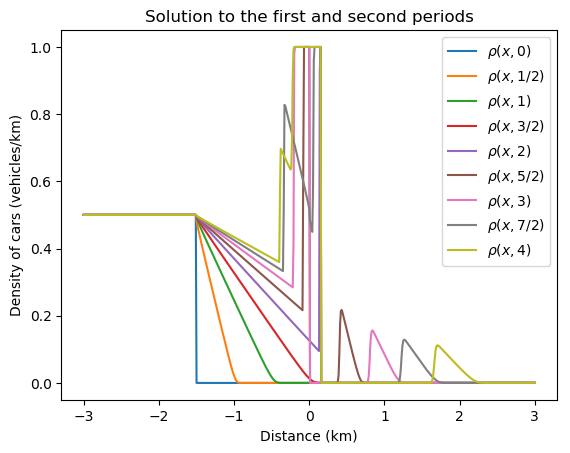

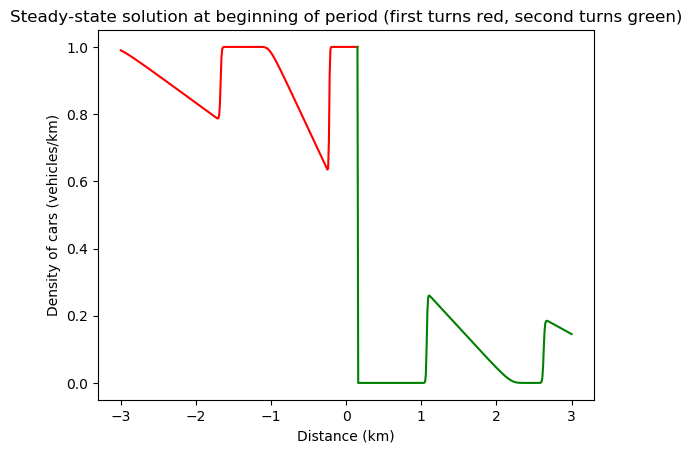

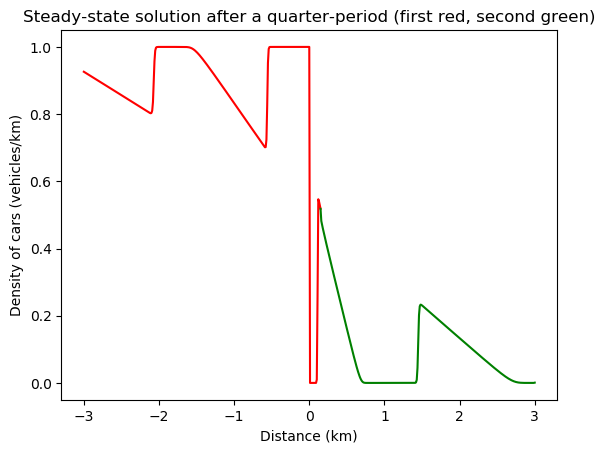

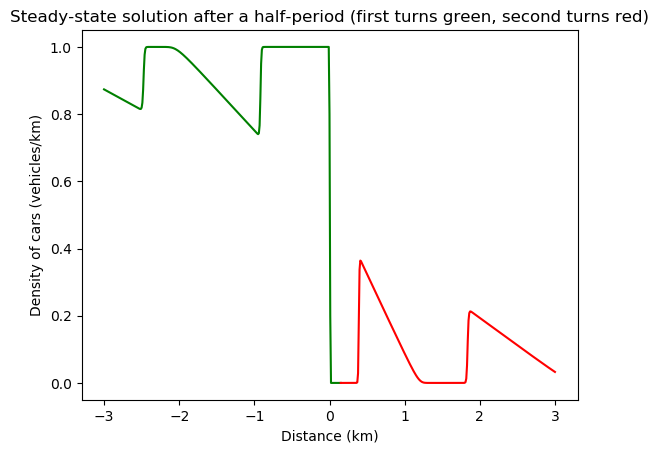

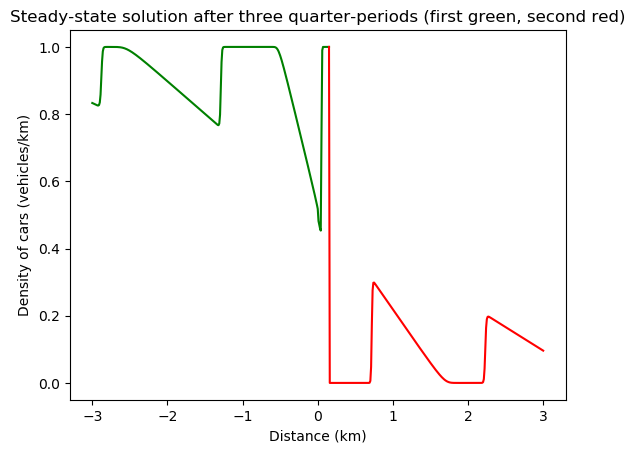

0.15


PyObject Text(0.5, 1.0, 'Steady-state solution after three quarter-periods (first green, second red)')

In [10]:
ρmax = 1.0
umax = 1.0
T = 2 
τ = 1.0
tol = 1e-9
x2 = 0.15

capacity, xq, ρq, ρ1, ρ2 = roadcapacity(ρmax, umax, T, τ, x2, tol)

println("The average flow (road capacity) over a time period of T=", T, " is ", capacity, ".")

figure(1)
plot(xq, ρ1[1, :], label = L"\rho(x,0)")
plot(xq, ρ1[Int64(round(m / 4)), :], label = L"\rho(x,1/2)")
plot(xq, ρ1[Int64(round(m / 2)), :], label = L"\rho(x,1)")
plot(xq, ρ1[Int64(round(3 * m / 4)), :], label = L"\rho(x,3/2)")
plot(xq, ρ1[m, :], label = L"\rho(x,2)")
plot(xq, ρ2[Int64(round(m / 4)), :], label = L"\rho(x,5/2)")
plot(xq, ρ2[Int64(round(m / 2)), :], label = L"\rho(x,3)")
plot(xq, ρ2[Int64(round(3 * m / 4)), :], label = L"\rho(x,7/2)")
plot(xq, ρ2[m, :], label = L"\rho(x,4)")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
legend()
title("Solution to the first and second periods")

loc2 = Int64(round((n / 2) + (0.15 / dx))) #index where x=0.15
println(xq[loc2])

figure(2)
plot(xq[1 : loc2], ρq[1, 1 : loc2], "r-")
plot(xq[loc2 : end], ρq[1, loc2 : end], "g-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution at beginning of period (first turns red, second turns green)")

figure(3)
plot(xq[1 : loc2], ρq[Int64(round(m / 4)) + 1, 1 : loc2], "r-")
plot(xq[loc2 : end], ρq[Int64(round(m / 4)) + 1, loc2 : end], "g-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after a quarter-period (first red, second green)")

figure(4)
plot(xq[1 : loc2], ρq[Int64(round(m / 2)) + 1, 1 : loc2], "g-")
plot(xq[loc2 : end], ρq[Int64(round(m / 2)) + 1, loc2 : end], "r-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after a half-period (first turns green, second turns red)")

figure(5)
plot(xq[1 : loc2], ρq[Int64(round(3 * m / 4)) + 1, 1 : loc2], "g-")
plot(xq[loc2 : end], ρq[Int64(round(3 * m / 4)) + 1, loc2 : end], "r-")
xlabel("Distance (km)")
ylabel("Density of cars (vehicles/km)")
title("Steady-state solution after three quarter-periods (first green, second red)")

Visually, we see that the steady-state periodic solution for the least optimal delay has much less density overall after the traffic lights than for the optimal delay case. Also, note that the optimal delay case is not unique: there are multiple optimal delays possible, as we can see from the graph.